In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [0]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [0]:
from pyspark.sql import SparkSession
from  pyspark.sql.types import IntegerType, FloatType

spark = SparkSession \
    .builder \
    .appName("douban movie recomendation") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [0]:
movies_df = spark.read.load("/FileStore/tables/movie_douban.csv", format='csv', header = True)
users_df = spark.read.load("/FileStore/tables/user.csv", format='csv', header = True)

In [0]:
#输出5条记录
users_df.take(5)
users_df.show(5)

+----+------------+-------------------+------+----------+----+
评分| 用户名| 评论时间|用户ID| 电影名|类型|
+----+------------+-------------------+------+----------+----+
 2| 身似|2018-01-05 15:05:06| 1| 心雨花露|爱情|
 4|有意识的贱民|2018-01-05 15:05:06| 3|战争的恐怖|战争|
 2| 亿万露电|2018-01-05 15:05:06| 4|豪勇七蛟龙|战争|
 2| Marni|2018-01-05 15:05:06| 5| 无序之主|犯罪|
 4| 马西嘻嘻嘻|2018-01-05 15:05:06| 6|时装店风波|同性|
+----+------------+-------------------+------+----------+----+
only showing top 5 rows

In [0]:
users_df.columns

Out[6]: ['评分', '用户名', '评论时间', '用户ID', '电影名', '类型']

In [0]:
users_df.printSchema()

root
-- 评分: string (nullable = true)
-- 用户名: string (nullable = true)
-- 评论时间: string (nullable = true)
-- 用户ID: string (nullable = true)
-- 电影名: string (nullable = true)
-- 类型: string (nullable = true)

In [0]:
movies_df.show(5)

+----+--------------------------------+--------+---------+----+----+-----------+
类型| 主演| 地区| 导演|特色|评分| 电影名|
+----+--------------------------------+--------+---------+----+----+-----------+
剧情| 徐峥|王传君|周一围|谭卓|章宇|中国大陆| 文牧野|经典| 8.9| 我不是药神|
剧情| 冯小刚|许晴|张涵予|刘桦|李易峰|中国大陆| 管虎|经典| 7.8| 老炮儿|
剧情|王宝强|刘昊然|肖央|刘承羽|尚语贤|中国大陆| 陈思诚|经典| 6.7|唐人街探案2|
剧情|任素汐|大力|刘帅良|裴魁山|阿如那|中国大陆|周申|刘露|经典| 8.3| 驴得水|
剧情| 徐峥|王宝强|李曼|李小璐|左小青|中国大陆| 叶伟民|经典| 7.5| 人在囧途|
+----+--------------------------------+--------+---------+----+----+-----------+
only showing top 5 rows

In [0]:
movies_df.groupby('电影名').count().show()

+----------------+-----+
 电影名|count|
+----------------+-----+
 美好2012| 1|
 六月男孩| 1|
 冬去春又来| 1|
2B青年的不醉人生| 2|
 鸡蛋和石头| 1|
 星星的孩子| 1|
 低俗小说| 23|
 八恶人| 14|
 爱情故事| 11|
 森林泰山| 10|
 寂静的地球| 5|
 4-D的恶梦| 4|
 牛仔裤的夏天2| 9|
 弗莉卡| 4|
 火爆小子| 2|
 正义法则| 2|
 亲爱的埃莉诺| 7|
亚瑟王：斗兽争霸| 7|
 绝命盗窃| 5|
 戏水女郎| 3|
+----------------+-----+
only showing top 20 rows

In [0]:
from pyspark.sql.functions import row_number, monotonically_increasing_id

movie_names_df = movies_df.select('电影名').distinct() 
print(f'movie numbers: {movie_names_df.count()}')
# users_df = users_df.withColumn("movieId", monotonically_increasing_id()+1)
movie_names_df = movie_names_df.withColumn("movieId", monotonically_increasing_id()+1)

movie numbers: 23034

In [0]:
movie_names_df.select('movieId').distinct().count()

Out[11]: 23034

In [0]:
movie_names_df.show(5)

+----------------+-------+
 电影名|movieId|
+----------------+-------+
 美好2012| 1|
 六月男孩| 2|
 冬去春又来| 3|
2B青年的不醉人生| 4|
 鸡蛋和石头| 5|
+----------------+-------+
only showing top 5 rows

In [0]:
gener_stats = movies_df.groupby('类型').count().orderBy('count', ascending=False)
display(gener_stats)

类型,count
剧情,24275
爱情,15160
喜剧,10960
动作,5271
犯罪,5051
惊悚,3984
奇幻,3741
悬疑,3237
冒险,3041
科幻,2772


In [0]:
movies_df = movies_df.join(movie_names_df, on = ['电影名'], how='left').select(movies_df['*'], movie_names_df['movieId'])

In [0]:
# movies_df = movies_df.drop('movieId')
# users_df.select('电影名').distinct().count()
# movies_df = movies_df.withColumn('movieId', movies_df['movieId'].cast(IntegerType()))
# movies_df = movies_df.drop('movieId')
movies_df.show(10)

+----+--------------------------------+--------+---------+----+----+-----------+-------+
类型| 主演| 地区| 导演|特色|评分| 电影名|movieId|
+----+--------------------------------+--------+---------+----+----+-----------+-------+
剧情| 徐峥|王传君|周一围|谭卓|章宇|中国大陆| 文牧野|经典| 8.9| 我不是药神| 18305|
剧情| 冯小刚|许晴|张涵予|刘桦|李易峰|中国大陆| 管虎|经典| 7.8| 老炮儿| 17402|
剧情|王宝强|刘昊然|肖央|刘承羽|尚语贤|中国大陆| 陈思诚|经典| 6.7|唐人街探案2| 13999|
剧情|任素汐|大力|刘帅良|裴魁山|阿如那|中国大陆|周申|刘露|经典| 8.3| 驴得水| 16599|
剧情| 徐峥|王宝强|李曼|李小璐|左小青|中国大陆| 叶伟民|经典| 7.5| 人在囧途| 14817|
剧情| 徐峥|黄渤|余男|多布杰|王双宝|中国大陆| 宁浩|经典| 8.1| 无人区| 18944|
剧情|姜文|香川照之|袁丁|姜宏波|丛志军|中国大陆| 姜文|经典| 9.2| 鬼子来了| 11549|
剧情|章子怡|黄晓明|张震|王力宏|陈楚生|中国大陆| 李芳芳|经典| 7.6| 无问西东| 17106|
剧情| 彭于晏|廖凡|姜文|周韵|许晴|中国大陆| 姜文|经典| 7.1| 邪不压正| 5785|
剧情| 肖央|王太利|韩秋池|于蓓蓓|中国大陆| 肖央|经典| 8.5| 11度青春之| 771|
+----+--------------------------------+--------+---------+----+----+-----------+-------+
only showing top 10 rows

In [0]:
movies_df.select('movieId').count()

Out[16]: 93160

In [0]:
# users_df = users_df.drop('movieId')
#refer:https://dzone.com/articles/pyspark-join-explained-with-examples
users_df = users_df.join(movie_names_df, on=['电影名'], how = 'left').select(users_df['*'], movie_names_df['movieId'])

In [0]:
rating_movie_num = users_df.select('movieId').distinct().count()
print(f'movie rating numbers: {rating_movie_num}')

movie rating numbers: 23031

In [0]:
rating_gerens_stats = users_df.groupby('类型').count().orderBy('count', ascending=False)
display(rating_gerens_stats)

类型,count
爱情,39649
犯罪,23318
奇幻,22532
剧情,18588
喜剧,13259
情色,10958
战争,9524
同性,8657
冒险,7847
音乐,7259


In [0]:
users_df = users_df.withColumnRenamed('评分','rating').withColumnRenamed('用户ID','userId')
users_df.show(10)

+------+------------+-------------------+------+--------------------+----+-------+
rating| 用户名| 评论时间|userId| 电影名|类型|movieId|
+------+------------+-------------------+------+--------------------+----+-------+
 2| 身似|2018-01-05 15:05:06| 1| 心雨花露|爱情| 21199|
 4|有意识的贱民|2018-01-05 15:05:06| 3| 战争的恐怖|战争| 6606|
 2| 亿万露电|2018-01-05 15:05:06| 4| 豪勇七蛟龙|战争| 7284|
 2| Marni|2018-01-05 15:05:06| 5| 无序之主|犯罪| 9675|
 4| 马西嘻嘻嘻|2018-01-05 15:05:06| 6| 时装店风波|同性| 1253|
 4| 坏蛋维尼?|2018-01-05 15:05:06| 8|幸福是一条温暖的毛毯|喜剧| 10040|
 4| 刘小黛|2018-01-05 15:05:06| 10| 变形金刚4：绝迹重生|冒险| 20125|
 4| Carf|2018-01-05 15:05:06| 11| 修女也疯狂|歌舞| 9568|
 4| papi|2018-01-05 15:05:06| 12| 无所畏惧|情色| 154|
 4| 鬼腳七|2018-01-05 15:05:06| 13| 血蝉|剧情| 16610|
+------+------------+-------------------+------+--------------------+----+-------+
only showing top 10 rows

In [0]:

users_df = users_df.withColumn('userId', users_df['userId'].cast(IntegerType()))\
                   .withColumn('movieId', users_df["movieId"].cast(IntegerType()))\
                   .withColumn('rating', users_df["rating"].cast(FloatType()))

In [0]:
users_df.printSchema()

root
-- rating: float (nullable = true)
-- 用户名: string (nullable = true)
-- 评论时间: string (nullable = true)
-- userId: integer (nullable = true)
-- 电影名: string (nullable = true)
-- 类型: string (nullable = true)
-- movieId: integer (nullable = true)

In [0]:
ratings_df = users_df.select(['userId','movieId', 'rating'])

In [0]:
ratings_df.show(10)

+------+-------+------+
userId|movieId|rating|
+------+-------+------+
 1| 21199| 2.0|
 3| 6606| 4.0|
 4| 7284| 2.0|
 5| 9675| 2.0|
 6| 1253| 4.0|
 8| 10040| 4.0|
 10| 20125| 4.0|
 11| 9568| 4.0|
 12| 154| 4.0|
 13| 16610| 4.0|
+------+-------+------+
only showing top 10 rows

In [0]:
movies_df.join(users_df, on=['movieId'], how='inner').select(movies_df['电影名'],movies_df['类型'], users_df['电影名'], users_df['类型']).distinct().toPandas().head(10)

Out[25]:

,电影名,类型,电影名,类型
0,黑道沉沦,剧情,黑道沉沦,犯罪
1,七处子,犯罪,七处子,犯罪
2,大上海1937,动作,大上海1937,武侠
3,妖铃铃,剧情,妖铃铃,恐怖
4,硬汉子,剧情,硬汉子,犯罪
5,我想戴上戒指,喜剧,我想戴上戒指,悬疑
6,猫和老鼠：回到奥兹,喜剧,猫和老鼠：回到奥兹,冒险
7,赤足惊魂,惊悚,赤足惊魂,情色
8,幸福59厘米之别闹，改日,剧情,幸福59厘米之别闹，改日,爱情
9,夏天的故事,剧情,夏天的故事,爱情


In [0]:
# movies_df = movies_df.join(users_df, on=['movieId'], how='left').select(movies_df['*'],users_df['类型'].alias('genres'))

In [0]:
movies_df.show(10)

+----+--------------------------------+--------+---------+----+----+-----------+-------+
类型| 主演| 地区| 导演|特色|评分| 电影名|movieId|
+----+--------------------------------+--------+---------+----+----+-----------+-------+
剧情| 徐峥|王传君|周一围|谭卓|章宇|中国大陆| 文牧野|经典| 8.9| 我不是药神| 18305|
剧情| 冯小刚|许晴|张涵予|刘桦|李易峰|中国大陆| 管虎|经典| 7.8| 老炮儿| 17402|
剧情|王宝强|刘昊然|肖央|刘承羽|尚语贤|中国大陆| 陈思诚|经典| 6.7|唐人街探案2| 13999|
剧情|任素汐|大力|刘帅良|裴魁山|阿如那|中国大陆|周申|刘露|经典| 8.3| 驴得水| 16599|
剧情| 徐峥|王宝强|李曼|李小璐|左小青|中国大陆| 叶伟民|经典| 7.5| 人在囧途| 14817|
剧情| 徐峥|黄渤|余男|多布杰|王双宝|中国大陆| 宁浩|经典| 8.1| 无人区| 18944|
剧情|姜文|香川照之|袁丁|姜宏波|丛志军|中国大陆| 姜文|经典| 9.2| 鬼子来了| 11549|
剧情|章子怡|黄晓明|张震|王力宏|陈楚生|中国大陆| 李芳芳|经典| 7.6| 无问西东| 17106|
剧情| 彭于晏|廖凡|姜文|周韵|许晴|中国大陆| 姜文|经典| 7.1| 邪不压正| 5785|
剧情| 肖央|王太利|韩秋池|于蓓蓓|中国大陆| 肖央|经典| 8.5| 11度青春之| 771|
+----+--------------------------------+--------+---------+----+----+-----------+-------+
only showing top 10 rows

In [0]:
ratings_df.registerTempTable("ratings")
movies_df.registerTempTable('movies')

In [0]:
%sql select * from movies order by movieId limit 50

类型,主演,地区,导演,特色,评分,电影名,movieId
剧情,何洁|陈威旭|窦骁|果味VC|童瑶,中国大陆,杨庆生|沈沁源|黄精甫|五百|金赫,青春,7.2,美好2012,1
剧情,翁晓迪|闵西丁|王思美|罗犀子,中国大陆,安占军,青春,6.8,六月男孩,2
剧情,张铭益,中国大陆,费聿竹,文艺,6.3,冬去春又来,3
喜剧,黄渤,中国大陆,黄渤,搞笑,6.3,2B青年的不醉人生,4
剧情,黄渤,中国大陆,黄渤,搞笑,6.3,2B青年的不醉人生,4
剧情,姚红贵|肖品高|刘小玲,中国大陆,黄骥,女性,7.2,鸡蛋和石头,5
剧情,梁静|朱江迪|金宏,中国大陆,陈苗,女性,6.4,星星的孩子,6
惊悚,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,文艺,8.8,低俗小说,7
动作,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,文艺,8.8,低俗小说,7
动作,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,搞笑,8.8,低俗小说,7


In [0]:
%sql select * from movies where movieId = 7

类型,主演,地区,导演,特色,评分,电影名,movieId
剧情,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,经典,8.8,低俗小说,7
剧情,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,搞笑,8.8,低俗小说,7
剧情,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,黑帮,8.8,低俗小说,7
喜剧,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,经典,8.8,低俗小说,7
喜剧,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,文艺,8.8,低俗小说,7
喜剧,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,搞笑,8.8,低俗小说,7
喜剧,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,黑帮,8.8,低俗小说,7
动作,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,经典,8.8,低俗小说,7
动作,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,文艺,8.8,低俗小说,7
动作,约翰·特拉沃尔塔|乌玛·瑟曼|阿曼达·普拉莫|蒂姆·罗斯|塞缪尔·杰克逊,美国,昆汀·塔伦蒂诺,搞笑,8.8,低俗小说,7


In [0]:
user_num = spark.sql('select count(distinct(userId)) as user_num from ratings').toPandas()
print(f'{user_num.iloc[0,0]} 位用户评价过电影')

13545 位用户评价过电影

In [0]:
movies_df.show(50)

+----+----------------------------------+--------+------------------------+----+----+------------------+-------+
类型| 主演| 地区| 导演|特色|评分| 电影名|movieId|
+----+----------------------------------+--------+------------------------+----+----+------------------+-------+
剧情| 徐峥|王传君|周一围|谭卓|章宇|中国大陆| 文牧野|经典| 8.9| 我不是药神| 18305|
剧情| 冯小刚|许晴|张涵予|刘桦|李易峰|中国大陆| 管虎|经典| 7.8| 老炮儿| 17402|
剧情| 王宝强|刘昊然|肖央|刘承羽|尚语贤|中国大陆| 陈思诚|经典| 6.7| 唐人街探案2| 13999|
剧情| 任素汐|大力|刘帅良|裴魁山|阿如那|中国大陆| 周申|刘露|经典| 8.3| 驴得水| 16599|
剧情| 徐峥|王宝强|李曼|李小璐|左小青|中国大陆| 叶伟民|经典| 7.5| 人在囧途| 14817|
剧情| 徐峥|黄渤|余男|多布杰|王双宝|中国大陆| 宁浩|经典| 8.1| 无人区| 18944|
剧情| 姜文|香川照之|袁丁|姜宏波|丛志军|中国大陆| 姜文|经典| 9.2| 鬼子来了| 11549|
剧情| 章子怡|黄晓明|张震|王力宏|陈楚生|中国大陆| 李芳芳|经典| 7.6| 无问西东| 17106|
剧情| 彭于晏|廖凡|姜文|周韵|许晴|中国大陆| 姜文|经典| 7.1| 邪不压正| 5785|
剧情| 肖央|王太利|韩秋池|于蓓蓓|中国大陆| 肖央|经典| 8.5| 11度青春之| 771|
剧情| 阿尔文|加内特|赫德兰|克里斯汀|...|中国大陆| 李安|经典| 8.4| 比利| 3681|
剧情| 王千源|秦海璐|张申英|刘谦|罗二羊|中国大陆| 张猛|经典| 8.4| 钢的琴| 3280|
剧情| 霍卫民|王笑天|罗芸|杨瑜珍|孙黎|中国大陆| 忻钰坤|经典| 8.6| 心迷宫| 13887|
剧情| 陈道明|巩俐|张慧雯|郭涛|刘佩琦|中国大陆| 张艺谋|经典| 7.8| 归来| 12508|
剧情| 周迅|金城武|张学友|池珍熙|曾志伟|中国大陆| 陈可辛|赵良骏|经典| 7.6| 如果| 14711|
剧情| 汤姆|克鲁斯|杰瑞米|雷纳|西蒙|...|中国大陆| 克里斯托弗|麦奎里|经典| 7.7| 碟中谍5| 14191|
剧情| 夏雨|李冰冰|龚蓓苾|高旗|吴超|中国大陆| 伍仕贤|经典| 8.1| 独自等待| 205|
剧情| 葛优|刘蓓|何冰|冯小刚|英达|中国大陆| 冯小刚|经典| 8.3| 甲方乙方| 18945|
剧情| 梁朝伟|刘德华|黎明|陈道明|陈慧琳|中国大陆| 刘伟强|麦兆辉|经典| 7.8| 无间道3| 6868|
剧情|甄子丹|洪金宝|熊黛林|黄晓明|樊少皇|中国大陆| 叶伟信|经典| 7.2| 叶问2| 3172|
剧情| 宋洋|姜武|袁文康|谭卓|王梓尘|中国大陆| 忻钰坤|经典| 8.2| 暴裂无声| 9383|
剧情| 刘亦菲|杨洋|罗晋|严屹宽|李纯|中国大陆|赵小丁|安东尼|拉默里纳拉|经典| 3.9| 三生三世十里桃花| 2059|
剧情| 姜文|巩俐|滕汝骏|钱明|陈志刚|中国大陆| 张艺谋|经典| 8.2| 红高粱| 5591|
剧情| 陶泽如|李岷城|嵇波|胡先煦|郑伟|中国大陆| 吴天明|经典| 8.0| 百鸟朝凤| 1712|
剧情| 葛优|徐帆|中国大陆| 冯小刚|经典| 7.8| 不见不散| 4594|
剧情| 徐静蕾|姜文|黄觉|焦晃|孙飞虎|中国大陆| 徐静蕾|经典| 7.5|一个陌生女人的来信| 12509|
剧情|魏敏芝|张慧科|田正达|高恩满|孙志梅|中国大陆| 张艺谋|经典| 7.5| 一个都不能少| 6391|
剧情| 姜文|李保田|瞿颖|刘信义|葛优|中国大陆| 张艺谋|经典| 8.1| 有话好好说| 3380|
剧情| 姜文|徐帆|宁静|陈佩斯|崔杰|中国大陆| 常光希|经典| 7.7| 宝莲灯| 9841|
剧情| 章子怡|郑昊|孙红雷|李滨|嵇波|中国大陆| 张艺谋|经典| 7.9| 我的父亲母亲| 1820|
剧情| 宫哲|金雅琴|张淑芳|孙捷|罗忠学|中国大陆| 马俪文|经典| 8.6| 我们俩| 15860|
剧情| 黄璐|杨幼安|贺运乐|张玉玲|张友平|中国大陆| 李杨|经典| 8.4| 盲山| 90|
剧情| 李连杰|关之琳|莫少聪|熊欣欣|刘洵|中国大陆| 徐克|经典| 7.7| 黄飞鸿之三| 19570|
剧情| 丁建华|中国大陆| 钱家骏|戴铁郎|经典| 8.7| 九色鹿| 18306|
剧情| 贾林|魏宗万|孙飞虎|李颖|中国大陆| 张建亚|经典| 8.4| 三毛从军记| 880|
剧情| 滕汝骏|刘烨|赵秀丽|陈好|龚业珩|中国大陆| 霍建起|经典| 8.5| 那山那人那狗| 7775|
剧情| 刘晓庆|姜文|郑在石|张光北|徐松子|中国大陆| 谢晋|经典| 9.0| 芙蓉镇| 3173|
剧情| 张国立|葛优|梁天|潘虹|马晓晴|中国大陆| 米家山|经典| 8.4| 顽主| 19457|
剧情| 梅根|福克斯|斯蒂芬|阿梅尔|威尔...|中国大陆| 戴夫|格林|经典| 6.3| 忍者神龟2| 311|
剧情| 章子怡|姜文|陈冲|刘烨|陆毅|中国大陆| 侯咏|经典| 7.2| 茉莉花开| 6064|
剧情| 宁静|邵兵|应真|保罗|克塞|中国大陆| 冯小宁|经典| 7.7| 红河谷| 15111|
剧情| 葛优|丁嘉丽|李滨|夏雨|李勤勤|中国大陆| 路学长|经典| 7.2| 卡拉是条狗| 5592|
剧情| 宁静|保罗|克塞|王新军|李明|中国大陆| 冯小宁|经典| 7.5| 黄河绝恋| 206|
剧情| 侯勇|穆立新|汤姆|巴特勒|JR|...|中国大陆| 宋业明|经典| 6.4| 冲出亚马逊| 7979|
剧情| 沈洁|张丰毅|张闽|郑振瑶|严翔|中国大陆| 吴贻弓|经典| 8.8| 城南旧事| 3084|
剧情| 郭柯宇|徐啸力|伊格尔|列达哥洛夫|中国大陆| 叶大鹰|经典| 7.5| 红樱桃| 12728|
剧情| 高圆圆|徐静蕾|邵兵|濮存昕|吕丽萍|中国大陆| 张杨|经典| 7.4| 爱情麻辣烫| 13474|
剧情| 安吉斯|张莹|葛存壮|吴克勤|王澍|中国大陆| 崔嵬|欧阳红樱|经典| 7.8| 小兵张嘎| 11259|
剧情| 白大钧|张长瑞|中国大陆| 唐英奇|经典| 8.0| 地雷战| 10707|
剧情| 李纬|韦伟|石羽|张鸿眉|崔超明|中国大陆| 费穆|经典| 8.6| 小城之春| 16695|
+----+----------------------------------+--------+------------------------+----+----+------------------+-------+
only showing top 50 rows

In [0]:
sql_movie_not_rating = 'SELECT distinct(movieId) FROM movies WHERE movieId NOT IN  (SELECT movieId From ratings)'
movies_no_rating = spark.sql(sql_movie_not_rating).toPandas()

In [0]:
pd_movies_names = movie_names_df.toPandas()
pd_movies_names.merge(movies_no_rating, on = 'movieId')

Out[32]:

,电影名,movieId
0,当狗狗在停车场,12725
1,粉骚大联盟,14383
2,新雪国,22190


In [0]:
## Part2: Spark ALS based approach for training model

Out[34]:

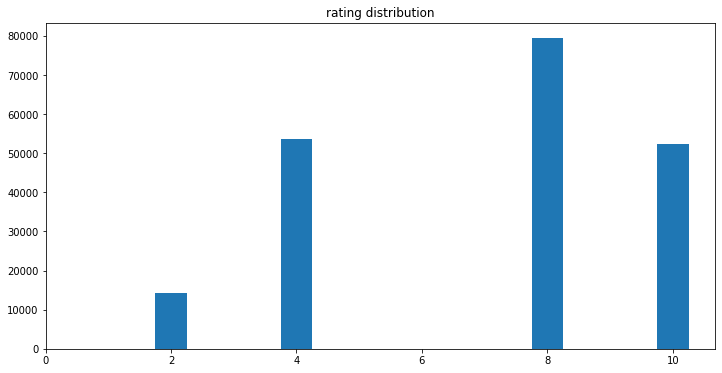

([<matplotlib.axis.XTick at 0x7f9023a41a00>,
 <matplotlib.axis.XTick at 0x7f9023a419d0>,
 <matplotlib.axis.XTick at 0x7f9035cf46a0>,
 <matplotlib.axis.XTick at 0x7f9023a142b0>,
 <matplotlib.axis.XTick at 0x7f9023a147c0>,
 <matplotlib.axis.XTick at 0x7f9023a14cd0>],
 <a list of 6 Text major ticklabel objects>)

In [0]:

rating_count = ratings_df.select('rating').groupby('rating').count().toPandas()

plt.figure(figsize = [12,6])
plt.bar(x='rating', height='count', data = rating_count, width = 0.5)
plt.title('rating distribution')
plt.xticks(np.arange(0,11,2))

In [0]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [0]:
#create test and train set
(training, test) = ratings_df.randomSplit([0.8,0.2])

In [0]:
# Create ALS model
model_als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", seed=23)          

In [0]:
# evaluation by RMSE
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [0]:
#tune model using ParaGridBuilder
# params = ParamGridBuilder()\
#                 .addGrid(model_als.maxIter, [3,5,10])\
#                 .addGrid(model_als.rank, [5,10,15,20,25])\
#                 .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
#                 .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
#                 .build()

params = ParamGridBuilder()\
                .addGrid(model_als.maxIter, [3,5])\
                .addGrid(model_als.rank, [5,10])\
                .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
                .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
                .build()
                         
# build cross validation
cv =CrossValidator(estimator=model_als,estimatorParamMaps=params,evaluator=evaluator,numFolds=5,seed=23)
                         
#Fit ALS model to training data
cv_model = cv.fit(training)

/databricks/spark/python/pyspark/ml/util.py:838: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
# ectract best model from best params group
best_model = cv_model.bestModel

In [0]:
# print best parameters
best_params=cv_model.getEstimatorParamMaps()[np.argmin(cv_model.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 3
-> rank: 5
-> regParam: 0.1
-> alpha: 0.1

In [0]:
#generate predictions and evaluate using RMSE
prediction_test = best_model.transform(test)

In [0]:
#Generate predictions and evaluate using RMSE
prediction_train =  best_model.transform(training)
prediction_train.

File "<command-1555419714367711>" , line 3 
 prediction_train. 
 ^
 SyntaxError : invalid syntax